In [1]:
# install tools
!pip install --upgrade setuptools
!pip install --upgrade pip
!pip install xgboost

In [2]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

**File descriptions as provided in the Kaggle competition webpage** <br>

train.csv - the training set <br>
test.csv - the test set <br>
data_description.txt - full description of each column, originally prepared by Dean De Cock but lightly edited to match the column names used here <br>
sample_submission.csv - a benchmark submission from a linear regression on year and month of sale, lot square footage, and number of bedrooms

In [3]:
%cd "C:\Users\uallakulov\ds_projects\capstone_houseprices"

C:\Users\uallakulov\ds_projects\capstone_houseprices


In [343]:
#import datasets
df_train = pd.read_csv(r"train.csv")
df_test = pd.read_csv(r"test.csv")

In [344]:
df_train.shape

(1460, 81)

In [345]:
df_test.shape

(1459, 80)

In [346]:
df_train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [347]:
#data description
desc = open("data_description.txt", "r")
print(desc.read())

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

# Data preprocessing

In [348]:
def percent_missing(df):
    '''
    Calculates the percentage of missing values in a dataset.
    
    Args:
    inputs: Dataset
    returns: Dataset showing the percentage of missing values per column.
    '''
    percent_missing = df.isnull().sum()* 100/len(df)
    percent_missing_df = pd.DataFrame({'col': df.columns,
                                 'percent_missing': percent_missing})
    return percent_missing_df

In [349]:
# calculate the percentage of missing values
missing_train = percent_missing(df_train)

In [350]:
# top 15 attributes in terms of missing values
missing_train["percent_missing"].sort_values(ascending = False).head(15)

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageCond       5.547945
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtFinType1     2.534247
BsmtCond         2.534247
Name: percent_missing, dtype: float64

Most variables have less than 6% values missing. For this analysis, I will drop variables that have more than 18% values missing, resulting in the elimination of 5 attributes.

In [351]:
#select columns to remove
missing_remove = list(missing_train[missing_train["percent_missing"]>19]["col"])
missing_remove

['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

In [352]:
train = df_train.drop(missing_remove, inplace = False, axis = 1)
test = df_test.drop(missing_remove, inplace = False, axis = 1)

In [353]:
train.shape, test.shape

((1460, 76), (1459, 75))

## Numerical continuous attributes

In [354]:
# engineer features using numeric attributes
def numeric_features(df):
    df['Total_indoor_area'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    df['Total_area'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF'] + df['GrLivArea'] + df['GarageArea']

    df['Total_bathrooms'] = (df['FullBath'] + (0.5 * df['HalfBath']) +
                             df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath']))
    df['Total_baths'] = df['FullBath'] + 0.5 * df['HalfBath']

    df['Total_lot_area'] = df['LotFrontage'] + df['LotArea']
    df['Total_porch_area'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['ScreenPorch']


    df['Total_finished_basement'] = df['BsmtFinSF1'] + df['BsmtFinSF2']

    df['Total_porch_area'] = (df['OpenPorchSF'] + df['3SsnPorch'] +
                            df['EnclosedPorch'] + df['ScreenPorch'] +
                            df['WoodDeckSF'])
    
    # create dummies based on numeric features
    df['Pool_dummy'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    df['2floor_dummy'] = df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
    df['Garage_dummy'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
    df['Basement_dummy'] = df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    df['Fireplace_dummy'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
    
    return df
    

In [358]:
train = numeric_features(train)
test = numeric_features(test)

In [359]:
train['LotFrontage'].head()

0    65.0
1    80.0
2    68.0
3    60.0
4    84.0
Name: LotFrontage, dtype: float64

In [360]:
pd.isnull(train).sum().sort_values(ascending=False)

LotFrontage       259
Total_lot_area    259
GarageQual         81
GarageFinish       81
GarageYrBlt        81
                 ... 
Fireplaces          0
GarageCars          0
GarageArea          0
PavedDrive          0
Id                  0
Length: 88, dtype: int64

In [361]:
# check the means of the numeric variables before imputing 
train[['LotFrontage','Total_lot_area','MasVnrArea', 'GarageYrBlt']].mean()

LotFrontage          70.049958
Total_lot_area    10021.748543
MasVnrArea          103.685262
GarageYrBlt        1978.506164
dtype: float64

In [362]:
from sklearn.impute import KNNImputer

# Impute numerical continuous attributes using the closest neighbors
# numeric attibutes with missing values
num_col = ['LotFrontage','Total_lot_area','MasVnrArea', 'GarageYrBlt', 'Total_area', 'Total_bathrooms', 'BsmtFullBath', 'BsmtHalfBath',
          'TotalBsmtSF', 'BsmtUnfSF', 'BsmtFinSF1', 'Total_indoor_area', 'BsmtFinSF2', 'Total_finished_basement', 'GarageArea', 'GarageCars']

#initialize imputer
knn_imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

# fit imputer on the combined dataset
for col in num_col:
    knn_imputer.fit(pd.concat([train[col], test[col]], axis=0, sort=False).values.reshape(-1, 1))
    
    #apply the imputer separately to the train and test dataset
    train[col] = knn_imputer.transform(train[col].values.reshape(-1, 1))
    test[col] = knn_imputer.transform(test[col].values.reshape(-1, 1))

In [366]:
# check that the means of the numerical attributes have decreased after imputation 
train[['LotFrontage','Total_lot_area','MasVnrArea', 'GarageYrBlt']].mean()

LotFrontage         69.917946
Total_lot_area    9981.619489
MasVnrArea         103.677130
GarageYrBlt       1978.484374
dtype: float64

In [368]:
# verify that only categorical attributes have missing values - to be imputed later
pd.isnull(train).sum().sort_values(ascending=False).head(12)

GarageCond      81
GarageQual      81
GarageFinish    81
GarageType      81
BsmtFinType2    38
BsmtExposure    38
BsmtCond        37
BsmtFinType1    37
BsmtQual        37
MasVnrType       8
Electrical       1
ExterCond        0
dtype: int64

## Categorical attributes

In [369]:
# list of categorical variables
categorical_col = ["MSSubClass","MSZoning", "Street", "LotShape", "LandContour", 
                   "Utilities", "LotConfig", "LandSlope", "Neighborhood", "Condition1",
                   "Condition2", "BldgType", "HouseStyle", "RoofStyle", "Exterior1st",
                   "Exterior2nd", "MasVnrType", "Foundation", "Heating", "Electrical", 
                   "GarageType", "SaleType", "SaleCondition", "CentralAir", "RoofMatl"]

In [370]:
# clean NAs in categorical attributes
def categorical_na(df):
    for col in categorical_col:
        df[col] = df[col].replace("NA", np.nan)
    
    return df

In [371]:
train = categorical_na(train)
test = categorical_na(test)

In [372]:
#now we should have equal number of columns
train.shape, test.shape

((1460, 88), (1459, 87))

In [373]:
# impute categorical attributes using the most frequent value
from sklearn.impute import SimpleImputer
simple_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

#fit imputer on the combined dataset
for col in categorical_col:
    simple_imputer.fit(pd.concat([train[col], test[col]], axis=0, sort=False).values.reshape(-1, 1))
    
    #apply the imputer separately to the train and test dataset
    train[col] = simple_imputer.transform(train[col].values.reshape(-1, 1))
    test[col] = simple_imputer.transform(test[col].values.reshape(-1, 1))

In [374]:
#length of the train set - I will needed to separate the concatenated set later
train_objs_num = len(train)

#concatenate the test and train sets
dataset = pd.concat(objs = [train, test], axis=0)

# get dummies on the combined data first
dataset_preprocessed  = pd.get_dummies(dataset, columns = categorical_col, prefix = categorical_col, dummy_na = False, drop_first = True)

# separate the test and train sets from the combined dataset
train = dataset_preprocessed[:train_objs_num]
test = dataset_preprocessed[train_objs_num:]

## Deal with ordinal attributes

In [376]:
# list of variables to be treated as ordinal
ordinal_col = ["OverallQual", "OverallCond", "ExterQual", "ExterCond", "BsmtQual", "BsmtCond", 
               "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "HeatingQC", "KitchenQual", 
               "Functional", "GarageFinish", "GarageQual", "GarageCond", 
               "PavedDrive"]

In [377]:
#check for missing values in the ordianl attributes
pd.isnull(train[ordinal_col]).sum().sort_values(ascending=False)

GarageCond      81
GarageQual      81
GarageFinish    81
BsmtFinType2    38
BsmtExposure    38
BsmtFinType1    37
BsmtCond        37
BsmtQual        37
PavedDrive       0
Functional       0
KitchenQual      0
HeatingQC        0
ExterCond        0
ExterQual        0
OverallCond      0
OverallQual      0
dtype: int64

In [378]:
# impute ordinal attributes using the most frequent value
from sklearn.impute import SimpleImputer
simple_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

#fit imputer on the combined dataset
for col in ordinal_col:
    simple_imputer.fit(pd.concat([train[col], test[col]], axis=0, sort=False).values.reshape(-1, 1))
    
    #apply the imputer separately to the train and test dataset
    train[col] = simple_imputer.transform(train[col].values.reshape(-1, 1))
    test[col] = simple_imputer.transform(test[col].values.reshape(-1, 1))

C:\Users\uallakulov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\uallakulov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\uallakulov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWar

In [43]:
#pd.isnull(train[ordinal_col]).sum().sort_values(ascending=False),
pd.isnull(test[ordinal_col]).sum().sort_values(ascending=False)

PavedDrive      0
GarageCond      0
GarageQual      0
GarageFinish    0
Functional      0
KitchenQual     0
HeatingQC       0
BsmtFinType2    0
BsmtFinType1    0
BsmtExposure    0
BsmtCond        0
BsmtQual        0
ExterCond       0
ExterQual       0
OverallCond     0
OverallQual     0
dtype: int64

In [44]:
# use ordinal encoder to encode strings to integers
from sklearn.preprocessing import OrdinalEncoder

# ["OverallQual", "OverallCond", "ExterQual", "ExterCond", "BsmtQual", "BsmtCond", 
               #"BsmtExposure", "BsmtFinType1", "BsmtFinType2", "HeatingQC", "KitchenQual", 
               #"Functional", "GarageFinish", "GarageQual", "GarageCond", 
              # "PavedDrive"]
            
ordinal1 = ["OverallQual", "OverallCond"]

ordinal2 = ["ExterQual", "ExterCond", "BsmtQual", "BsmtCond", 'HeatingQC', 'KitchenQual', 'GarageQual', 'GarageCond']

ordinal3 = ['BsmtExposure']
ordinal4 = ['BsmtFinType1', 'BsmtFinType2']
ordinal5 = ['Functional']
ordinal6 = ['GarageFinish']
ordinal7 = ['PavedDrive']



encoder1 = OrdinalEncoder(categories = [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]) 
encoder2 = OrdinalEncoder(categories = [['Po', 'Fa', 'TA', 'Gd', 'Ex']])
encoder3 = OrdinalEncoder(categories =[['No', 'Mn', 'Av', 'Gd']])
encoder4 = OrdinalEncoder(categories =[['Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']])
encoder5 = OrdinalEncoder(categories =[['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ']])
encoder6 = OrdinalEncoder(categories =[['Unf', 'RFn', 'Fin']])
encoder7 = OrdinalEncoder(categories =[['N', 'P', 'Y']])



In [45]:
#train[["OverallQual", "OverallCond"]]

In [46]:
for col in ordinal1:
    encoder1.fit(pd.concat([train[col], test[col]], axis=0, sort=False).values.reshape(-1, 1))
    
    #apply the imputer separately to the train and test dataset
    train[col] = encoder1.transform(train[col].values.reshape(-1, 1))
    test[col] = encoder1.transform(test[col].values.reshape(-1, 1))

C:\Users\uallakulov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\uallakulov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\uallakulov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

In [379]:
for col in ordinal2:
    encoder2.fit(pd.concat([train[col], test[col]], axis=0, sort=False).values.reshape(-1, 1))
    
    #apply the imputer separately to the train and test dataset
    train[col] = encoder2.transform(train[col].values.reshape(-1, 1))
    test[col] = encoder2.transform(test[col].values.reshape(-1, 1))

C:\Users\uallakulov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\uallakulov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\uallakulov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

In [380]:
for col in ordinal3:
    encoder3.fit(pd.concat([train[col], test[col]], axis=0, sort=False).values.reshape(-1, 1))
    
    #apply the imputer separately to the train and test dataset
    train[col] = encoder3.transform(train[col].values.reshape(-1, 1))
    test[col] = encoder3.transform(test[col].values.reshape(-1, 1))

C:\Users\uallakulov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\uallakulov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [381]:
for col in ordinal4:
    encoder4.fit(pd.concat([train[col], test[col]], axis=0, sort=False).values.reshape(-1, 1))
    
    #apply the imputer separately to the train and test dataset
    train[col] = encoder4.transform(train[col].values.reshape(-1, 1))
    test[col] = encoder4.transform(test[col].values.reshape(-1, 1))

C:\Users\uallakulov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\uallakulov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\uallakulov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

In [382]:
for col in ordinal5:
    encoder5.fit(pd.concat([train[col], test[col]], axis=0, sort=False).values.reshape(-1, 1))
    
    #apply the imputer separately to the train and test dataset
    train[col] = encoder5.transform(train[col].values.reshape(-1, 1))
    test[col] = encoder5.transform(test[col].values.reshape(-1, 1))

C:\Users\uallakulov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\uallakulov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [383]:
for col in ordinal6:
    encoder6.fit(pd.concat([train[col], test[col]], axis=0, sort=False).values.reshape(-1, 1))
    
    #apply the imputer separately to the train and test dataset
    train[col] = encoder6.transform(train[col].values.reshape(-1, 1))
    test[col] = encoder6.transform(test[col].values.reshape(-1, 1))

C:\Users\uallakulov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\uallakulov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [384]:
for col in ordinal7:
    encoder7.fit(pd.concat([train[col], test[col]], axis=0, sort=False).values.reshape(-1, 1))
    
    #apply the imputer separately to the train and test dataset
    train[col] = encoder7.transform(train[col].values.reshape(-1, 1))
    test[col] = encoder7.transform(test[col].values.reshape(-1, 1))

C:\Users\uallakulov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\uallakulov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [385]:
pd.isnull(train).sum().sort_values(ascending=False)

RoofMatl_WdShngl     0
MSSubClass_75        0
MSZoning_RL          0
MSZoning_RH          0
MSZoning_FV          0
                    ..
HouseStyle_SFoyer    0
HouseStyle_2Story    0
HouseStyle_2.5Unf    0
HouseStyle_2.5Fin    0
Id                   0
Length: 223, dtype: int64

# Descriptive statistics on the preprocessed dataset

In [386]:
train.columns

Index(['Id', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond',
       ...
       'SaleCondition_Normal', 'SaleCondition_Partial', 'CentralAir_Y',
       'RoofMatl_CompShg', 'RoofMatl_Membran', 'RoofMatl_Metal',
       'RoofMatl_Roll', 'RoofMatl_Tar&Grv', 'RoofMatl_WdShake',
       'RoofMatl_WdShngl'],
      dtype='object', length=223)

In [387]:
# gather all numerical attributes by combinining
num_attributes = num_col + ordinal_col

In [436]:
# dataset of numerical values for constructing a correllation matrix
df_corr = train[num_attributes]
df_corr['SalePrice'] = train['SalePrice']
df_corr.tail()

C:\Users\uallakulov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,LotFrontage,Total_lot_area,MasVnrArea,GarageYrBlt,Total_area,Total_bathrooms,BsmtFullBath,BsmtHalfBath,TotalBsmtSF,BsmtUnfSF,...,BsmtFinType1,BsmtFinType2,HeatingQC,KitchenQual,Functional,GarageFinish,GarageQual,GarageCond,PavedDrive,SalePrice
1455,62.0,7979.0,0.0,1999.0,4707.0,2.5,0.0,0.0,953.0,953.0,...,0.0,0.0,4.0,2.0,7.0,1.0,2.0,2.0,2.0,175000.0
1456,85.0,13260.0,119.0,1978.0,6188.0,3.0,1.0,0.0,1542.0,589.0,...,4.0,2.0,2.0,2.0,6.0,0.0,2.0,2.0,2.0,210000.0
1457,66.0,9108.0,0.0,1941.0,6084.0,2.0,0.0,0.0,1152.0,877.0,...,5.0,0.0,4.0,3.0,7.0,1.0,2.0,2.0,2.0,266500.0
1458,68.0,9785.0,0.0,1950.0,3474.0,2.0,1.0,0.0,1078.0,0.0,...,5.0,2.0,3.0,3.0,7.0,0.0,2.0,2.0,2.0,142125.0
1459,75.0,10012.0,0.0,1965.0,4044.0,2.5,1.0,0.0,1256.0,136.0,...,3.0,1.0,3.0,2.0,7.0,2.0,2.0,2.0,2.0,147500.0


In [437]:
df_corr.shape

(1460, 33)

<AxesSubplot:>

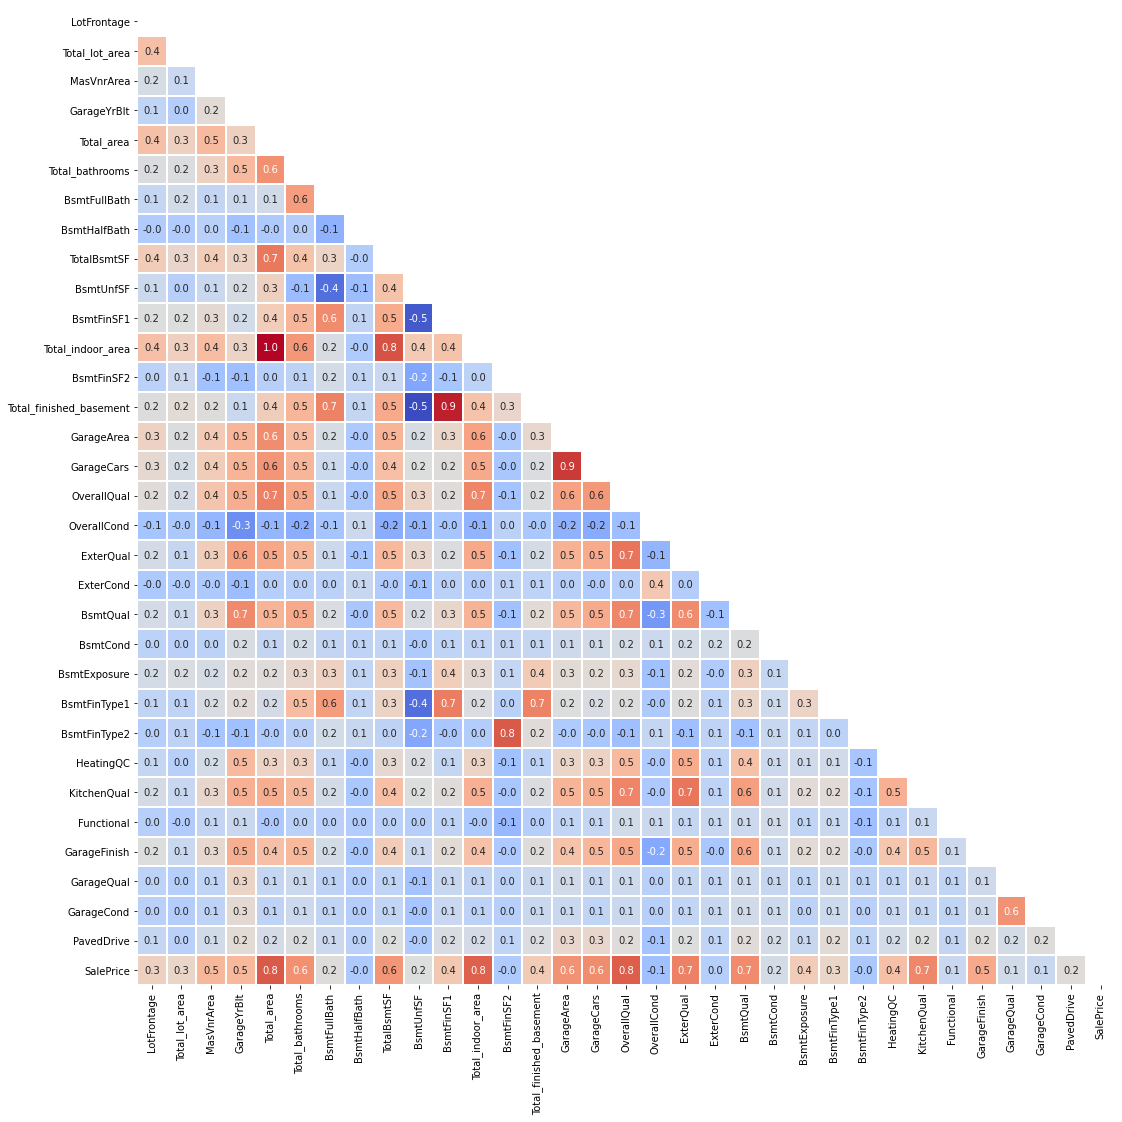

In [438]:
# correlation values
corr = df_corr.corr()

#graph
mask = np.triu(corr)
plt.figure(figsize=(18, 18))
sns.heatmap(corr,
            annot=True,
            fmt='.1f',
            cmap='coolwarm',
            square=True,
            mask=mask,
            linewidths=1,
            cbar=False)

The last row shows the correlation values of different attributes with the sale price. As can be seen, some attributes (dark red) are positively correlation with the sale prices, whereas others (dark blue) are negatively correlated. In the meantime, so attributes have zero correlation with the sale price, meaning they will bring almost no explanatory power in our predictive model. Also, there are a few strong correlations within the explanatory variables, which may cause multicollinearity in regression models. 

## Principal component analysis

In [463]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# Create dataframe for all numerica values
df_pca = train
# Standardize
x = MinMaxScaler().fit_transform(df_pca)
# Apply PCA
pca = PCA()
principalComponents = pca.fit_transform(x) 
#plt.figure(figsize = (15, 8))  
#p = sns.barplot(np.arange(1,len(df_pca.columns+1),1), pca.explained_variance_ratio_)

In [464]:
principalComponents[:,0:6]  

array([[ 1.65043454,  0.78571866,  0.11074293, -0.1849408 , -1.34531549,
        -0.55594986],
       [-0.60042767, -0.80584319,  0.26610427, -0.28484046,  0.3241323 ,
         0.91153928],
       [ 1.98587502,  0.65840352,  0.53279005, -0.32228344, -0.61342501,
        -0.41950543],
       ...,
       [ 0.15132621,  0.81809345,  0.56882954, -0.19791643,  0.38347498,
         0.51398894],
       [-1.18652105, -1.13746282,  0.01086721,  0.34976975, -0.0617917 ,
         0.28801922],
       [-0.7640798 , -0.87490979,  0.36318478, -0.64850463, -0.55898822,
         0.43428251]])

In [465]:
df_corr[["PC1","PC2"]] = principalComponents[:,0:2]  

C:\Users\uallakulov\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:659: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[k] = np.nan
C:\Users\uallakulov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\uallakulov\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be se

In [466]:
#df_corr.head(20)

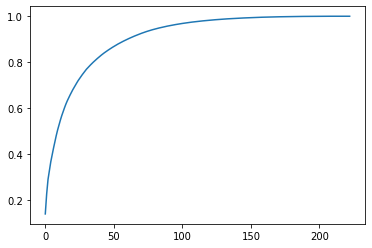

In [467]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [468]:
len(df_pca.columns)

223

C:\Users\uallakulov\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


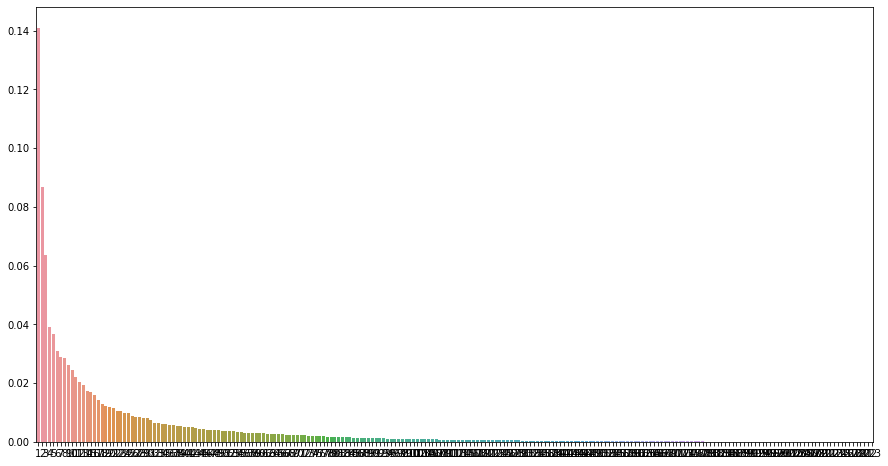

In [469]:
plt.figure(figsize = (15, 8))  
p = sns.barplot(np.arange(1,224,1), pca.explained_variance_ratio_)

## Remove outliers

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

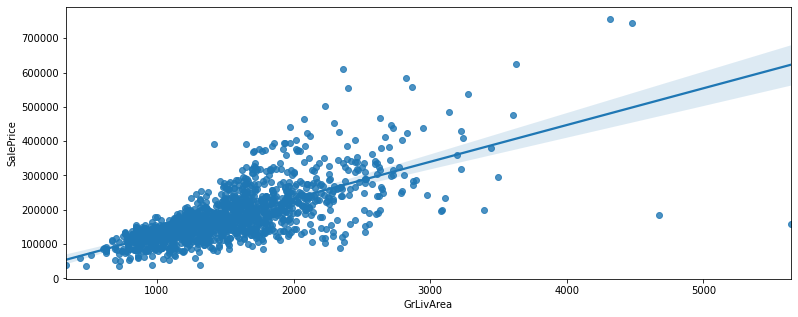

In [450]:
# check for outliers


plt.figure(figsize=(13,5))
sns.regplot(x=train['GrLivArea'], y=train['SalePrice'])

<AxesSubplot:xlabel='SalePrice'>

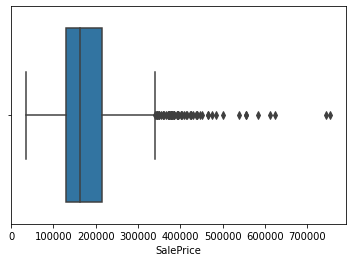

In [451]:
sns.boxplot(x=train['SalePrice'])

In [447]:
# capture four outliers
outliers = np.where(train['GrLivArea'] > 4500)[0]
outliers

array([ 523, 1298], dtype=int64)

In [462]:
train.head()

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,...,SaleCondition_Normal,SaleCondition_Partial,CentralAir_Y,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl
0,1,65.0,8450,7,5,2003,2003,196.0,3.0,2.0,...,1,0,1,1,0,0,0,0,0,0
1,2,80.0,9600,6,8,1976,1976,0.0,2.0,2.0,...,1,0,1,1,0,0,0,0,0,0
2,3,68.0,11250,7,5,2001,2002,162.0,3.0,2.0,...,1,0,1,1,0,0,0,0,0,0
3,4,60.0,9550,7,5,1915,1970,0.0,2.0,2.0,...,0,0,1,1,0,0,0,0,0,0
4,5,84.0,14260,8,5,2000,2000,350.0,3.0,2.0,...,1,0,1,1,0,0,0,0,0,0


In [30]:
#drop the outliers from the train set
train = train.drop(train.index[outliers])

Next, I will create dummy variables using the categorical attributes. To do that, I first concatenatate the train and test datasets. This will ensure that the resulting new columns will be created using the categories in both datasets. Next, I split the concatenated datasets back to training and test sets. 

In [31]:
#drop the id column and save with the training and test datasets with different names
train = train.drop("Id", axis = 1, inplace = False)
test = test.drop("Id", axis = 1, inplace = False)

In [32]:
#compare the columns
list(set(train.columns) - set(test.columns))

['SalePrice']

In [33]:
# keep the price column separately and drop it from the train dataset
SalePrice = train['SalePrice']
train.drop('SalePrice', inplace = True, axis = 1) 

In [473]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import tree
from matplotlib import pyplot
 
 
# get a list of models to evaluate
def get_models():
    models = dict()

    for i in range(1,21):
        steps = [('pca', PCA(n_components=i)), ('m', GradientBoostingRegressor(random_state = 10))]
        models[str(i)] = Pipeline(steps=steps)
    return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores
 
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.xticks(rotation=45)
pyplot.show()

C:\Users\uallakulov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\uallakulov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\uallakulov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

In [56]:
aaaaa

NameError: name 'aaaaa' is not defined

In [57]:
train.shape, test.shape

((1456, 220), (1459, 220))

In [58]:
pd.isnull(test).sum().sort_values(ascending = False)

RoofMatl_WdShngl     0
MSSubClass_80        0
MSZoning_RM          0
MSZoning_RL          0
MSZoning_RH          0
                    ..
HouseStyle_SLvl      0
HouseStyle_SFoyer    0
HouseStyle_2Story    0
HouseStyle_2.5Unf    0
LotFrontage          0
Length: 220, dtype: int64

## Prepare datasets for ML

In [59]:
# convert all columns to float
X = train.astype(float)

# targets 
y = SalePrice.values

# set for Kaggle prediction
X_test = test.astype(float)

# iterative imputer

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
iter_imp = IterativeImputer(max_iter=10, random_state=0)

iter_train=pd.DataFrame(iter_imp.fit_transform(x_train))
iter_train.columns=x_train.columns
iter_train.index=x_train.index

# ML models

In [ ]:
%cd "C:\Users\uallakulov\ds_projects\capstone_houseprices"

In [179]:
import numpy as np
import pandas as pd


from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBRegressor
import xgboost as xgb

# XGBRegressor
kfold = KFold(n_splits=3, random_state=10, shuffle=True)

pipeline1 = Pipeline([
        ('scaler', MinMaxScaler()),         
        ('XGB', XGBRegressor())
    ])
    
parameters1 = {
        'XGB__random_state': [10],
        'XGB__max_depth': [3],
        'XGB__n_estimators': [1000],
        'XGB__learning_rate': [0.029],
        'XGB__min_child_weight': [0.34],
        'XGB__subsample': [0],
        'XGB__colsample_bytree': [0.06],
        'XGB__colsample_bylevel': [0.05]
    }
#'x_colsample_bylevel': 5, 'x_colsample_bytree': 6, 'x_learning_rate': 29, 'x_max_depth': 3, 'x_min_child_weight': 34, 'x_n_estimators': 1, 'x_subsample': 0

# grid search with negative rmse scoring 
gs_xgb_rmse = GridSearchCV(pipeline1, param_grid = parameters1, n_jobs = 10, cv = kfold, scoring = 'neg_mean_squared_log_error', verbose=True)

In [180]:
gs_xgb_rmse.fit(X, y)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of   3 | elapsed:    0.9s finished


GridSearchCV(cv=KFold(n_splits=3, random_state=10, shuffle=True),
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('XGB',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     gamma=None, gpu_id=None,
                                                     importance_type='gain',
                                                     interaction_constraints=None,
                                                     learning_rate=None,
                                                     max_delta_step=None,
                                                     max_d...
       

In [181]:
gs_xgb_rmse.best_score_ 

-135.09975904812367

In [160]:
gs_xgb_rmse.best_params_

{'XGB__colsample_bylevel': 0.5,
 'XGB__colsample_bytree': 0.12,
 'XGB__learning_rate': 29,
 'XGB__max_depth': 2,
 'XGB__min_child_weight': 9,
 'XGB__n_estimators': 13,
 'XGB__n_iter': 200,
 'XGB__random_state': 10,
 'XGB__subsample': 0.14}

In [161]:
pred_xgb_rmse = gs_xgb_rmse.predict(X_test)

In [149]:
submission_xgb_rmse = pd.DataFrame()
submission_xgb_rmse['Id'] = df_test['Id']
submission_xgb_rmse['SalePrice'] = pred_xgb_rmse
submission_xgb_rmse.to_csv('submission_xgb_rmse.csv', index=False)

In [82]:
!pip install hyperopt
from hyperopt import hp, fmin, tpe, rand, STATUS_OK, Trials

In [275]:
y_scaled.mean()

0.0

In [162]:
import time
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_log_error

#initialize scaler
scaler = MinMaxScaler()
scaler1 = MinMaxScaler()
X_scaled = pd.DataFrame()
X_test_scaled = pd.DataFrame()
y_scaled = pd.DataFrame()

# fit scaler on the combined dataset
scaler.fit(pd.concat([X, X_test], axis=0, sort=False).values.reshape(-1, 1))

    
#apply the scaler separately to the train and test dataset
X_scaled = scaler.transform(X)
X_test_scaled = scaler.transform(X_test)
y_scaled = scaler1.fit_transform(y.reshape(1, -1)).reshape(-1, 1)

# Declare xgboost search space for Hyperopt
xgboost_space={
            'max_depth': hp.choice('x_max_depth',[2,3,4,5,6]),
            'min_child_weight':hp.choice('x_min_child_weight',np.arange(0.1,0.9,0.2)),
            'learning_rate':hp.choice('x_learning_rate',np.arange(0.01,0.3,0.05)),
            'subsample':hp.choice('x_subsample',np.arange(0.1,1.0,0.05)),
            'colsample_bylevel':hp.choice('x_colsample_bylevel',(np.arange(0.1,1.0,0.05)),
            'colsample_bytree':hp.choice('x_colsample_bytree',(np.arange(0.1,1.0,0.05)),
            'n_estimators':hp.choice('x_n_estimators', 1000)
            }

best_score = 0.05

def objective(space):
    best_score = 0.05
    model = XGBRegressor(**space, n_jobs=-1)   
    kfold = KFold(n_splits=3, random_state=10, shuffle=True)
    score = -cross_val_score(model, X_scaled, y_scaled, cv=kfold, scoring='neg_mean_squared_log_error', verbose=False).mean()
    
    if (score < best_score):
        best_score = score
    
    return score

start = time.time()

best = fmin(
  objective, 
  space = xgboost_space, 
  algo = tpe.suggest, 
  max_evals = 200,
  trials = Trials())

print("Hyperopt search took %.2f seconds for 200 candidates" % ((time.time() - start)))
print("Best score: %.2f " % (-best_score))
print("Best space: ", best)         

100%|██████████| 200/200 [21:43<00:00,  6.52s/trial, best loss: 1.9636373861190906e-90]
Hyperopt search took 1303.07 seconds for 200 candidates
Best score: -0.05 
Best space:  {'x_colsample_bylevel': 5, 'x_colsample_bytree': 6, 'x_learning_rate': 29, 'x_max_depth': 3, 'x_min_child_weight': 34, 'x_n_estimators': 1, 'x_subsample': 0}


In [183]:
!pip install hpsklearn

  Created wheel for hpsklearn: filename=hpsklearn-0.1.0-py3-none-any.whl size=23913 sha256=3e29cdace2002d0b53fb8d03d2bffb8a6ea6bdb6917cb6186ef63e68035661e7
  Stored in directory: c:\users\uallakulov\appdata\local\pip\cache\wheels\b2\22\23\9207fbe861f70774b563f909a415b228450bfcf863c64ac1e8
Successfully built hpsklearn


In [229]:
#pip list

In [210]:
!pip install git+https://github.com/hyperopt/hyperopt-sklearn.git

  Cloning https://github.com/hyperopt/hyperopt-sklearn.git to c:\users\uallak~1\appdata\local\temp\pip-req-build-j579_qj3


In [278]:
from hpsklearn import HyperoptEstimator, xgboost_regression, any_regressor

start = time.time()
model = HyperoptEstimator(regressor=xgboost_regression('reg'), 
                          algo=tpe.suggest, max_evals=250, trial_timeout=30)
print("Hyperopt search took %.2f seconds for 250 candidates" % ((time.time() - start)))

Hyperopt search took 0.00 seconds for 250 candidates


In [279]:
# reshape X
X_reshape = X.values
X_reshape

array([[6.500e+01, 8.450e+03, 6.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [8.000e+01, 9.600e+03, 5.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [6.800e+01, 1.125e+04, 6.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [6.600e+01, 9.042e+03, 6.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [6.800e+01, 9.717e+03, 4.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [7.500e+01, 9.937e+03, 4.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00]])

In [282]:
model.fit(X_reshape, y)

100%|██████████| 250/250 [00:10<00:00, 10.02s/trial, best loss: 0.08255237847380148]
[01:07:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


In [288]:
model.score(X_reshape, y)

0.9617187166443268

In [284]:
model.best_model()

{'learner': XGBRegressor(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.5136800468902291, colsample_bynode=1,
              colsample_bytree=0.8974466781606908, gamma=0.019380411766720496,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.00948793569304177, max_delta_step=0, max_depth=2,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=2200, n_jobs=1, num_parallel_tree=1,
              objective='reg:linear', random_state=1,
              reg_alpha=0.16236875067194606, reg_lambda=3.389408531380033,
              scale_pos_weight=1, seed=1, subsample=0.7052523797344689,
              tree_method='exact', validate_parameters=1, verbosity=None),
 'preprocs': (MinMaxScaler(feature_range=(0.0, 1.0)),),
 'ex_preprocs': ()}

In [322]:
from hpsklearn import HyperoptEstimator, xgboost_regression, gradient_boosting_regression

gbs_model = HyperoptEstimator(regressor=gradient_boosting_regression('reg'), 
                          algo=tpe.suggest, max_evals=800, trial_timeout=30)

In [323]:
pd.isnull(y).sum()

0

In [324]:
gbs_model.fit(X_reshape, y)

100%|█████████▉| 648/649 [00:00<?, ?trial/s, best loss=?]

job exception: Input contains NaN, infinity or a value too large for dtype('float64').



100%|█████████▉| 648/649 [00:03<?, ?trial/s, best loss=?]


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [299]:
gbs_model.score(X_reshape, y)

0.9661748301831247

In [300]:
gbs_model.best_model()

{'learner': GradientBoostingRegressor(alpha=0.9144095727490483,
                           learning_rate=0.0358256137031787, loss='huber',
                           max_features=0.07115524608126639, min_samples_leaf=9,
                           n_estimators=772, presort='auto', random_state=0,
                           subsample=0.7625070064197007),
 'preprocs': (),
 'ex_preprocs': ()}

In [301]:
pred_gbs_model = gbs_model.predict(X_test)

In [302]:
submission_gbs_model = pd.DataFrame()
submission_gbs_model['Id'] = df_test['Id']
submission_gbs_model['SalePrice'] = pred_gbs_model
submission_gbs_model.to_csv('submission_gbs_model.csv', index=False)

In [272]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from hyperopt import hp, fmin, tpe
from hyperopt.pyll import scope

#scope.define(GradientBoostingRegressor)    
    
def train_GradientBoostingRegressor(Xdata, Ydata, loss='ls', alpha = 0.50, cv = 5, n_steps = 10):
    """
    Trains a Gradient Boosting Regressor using bayesian optimization 

    Parameters
    ----------
    Xdata: numpy array of size KxN and composed of floating and/or integers
    Ydata: numpy array of size K (1D array) of floating
    loss: loss function to be optimized.
    alpha: quantile for the quantile and hubber loss; floating < 1.0 and > 0.0
    CV: K-fold cross-validation size for the training procedure
    n_steps: Number of times the `hyperopt` mimizer will run to find the optimal parameters
    
    Returns
    -------
    Regressor : A sckiki-learn obkect with the trained Gradient Boosting Regressor
    
    """
    #split data
    X_train, X_test, y_train, y_test = train_test_split(Xdata, Ydata, test_size=.33, random_state = 10)
    
    # create and objective function
    def objective_function_regression(estimator):
        mae_array = cross_val_score( estimator, X_train, y_train, cv= cv, n_jobs=-1, 
                                    scoring = make_scorer(mse))
        return mae_array.mean()


    # search space
    n_estimators     = hp.choice('n_estimators', np.arange(1000, 4000, 500)) 
    learning_rate    = hp.choice('x_learning_rate',np.arange(0.001,0.041,0.05))
    max_depth        = hp.choice('max_depth', np.arange(4, 16, 2))
    max_features     = hp.choice('max_features', np.arange(100, 220, 20))
    min_samples_leaf = hp.choice('min_samples_leaf', np.arange(2, 12, 2))
    #criterion        = hp.choice('criterion', ['friedman_mse'])
                                       
    # model / estimator to be optimized
    est0 = (0.1, scope.GradientBoostingRegressor( n_estimators  = n_estimators + 1,
                                            learning_rate = learning_rate,
                                            max_depth = max_depth + 1,
                                            max_features = max_features + 1,
                                            min_samples_leaf = min_samples_leaf + 1,
                                            random_state= 101) 
        )

    # search space
    search_space_regression = hp.pchoice('estimator', [est0])
    
    #print('--'*20)
    #print('Finding optimal parameters')
    # perform the optimization
    
    start = time.time()
    
    best = fmin(
    fn= objective_function_regression,
    space= search_space_regression,
    algo = tpe.suggest, # This is the optimization algorithm hyperopt uses, a tree of parzen estimators
    max_evals = n_steps,
    verbose = 1  # The number of iterations
         )
    
    print("Search took %.2f seconds" % ((time.time() - start)))
    
    # Allocate optimized parameters and apply to test data set
    Regressor = GradientBoostingRegressor( learning_rate = best['learning_rate'],
                          max_depth = best['max_depth'],
                          max_features = best['max_features'],
                          min_samples_leaf = best['min_samples_leaf'],
                          n_estimators = best['n_estimators'],
                          random_state = 10
                                       )
    # fit
    Regressor.fit(X_train,y_train)
    
    #evaluate
    yhat = Regressor.predict(X_test) ;
    error = np.sqrt(((yhat - y_test) ** 2).mean())
    #print('--'*20)
    
    print(  
        "{} {}".format('The RMSE score for the test set is :', error_pct) 
          )
    
    return Regressor, y_test, yhat







In [273]:
train_GradientBoostingRegressor(X, y)

  0%|          | 0/10 [02:32<?, ?trial/s, best loss=?]


KeyboardInterrupt: 

In [121]:
from sklearn.ensemble import GradientBoostingRegressor

pipeline_gbr = Pipeline([
        ('scaler', MinMaxScaler()),
        ('GFR', GradientBoostingRegressor())
    ])
    
parameters_gbr = {
        'GFR__learning_rate': [0.1, 0.2],
        'GFR__random_state': [10],
        'GFR__max_depth': [3, 4],
        'GFR__n_estimators': [500, 1000],
        'GFR__subsample': [0.5, 1],
        'GFR__criterion': ["friedman_mse", "mse", "mae"], 
        'GFR__tol': [0.01],
        'GFR__n_iter_no_change': [10]
    }

gs_gbr = GridSearchCV(pipeline_gbr, param_grid = parameters_gbr, n_jobs = 10, scoring='neg_root_mean_squared_error', cv = 5, verbose=True)

In [ ]:
gs_gbr.fit(X, y)

In [ ]:
gs_gbr.best_score_

In [ ]:
gs_gbr.best_params_

In [ ]:
pred_gbr = gs_gbr.predict(X_test)

In [ ]:
submission_gbr = pd.DataFrame()
submission_gbr['Id'] = df_test['Id']
submission_gbr['SalePrice'] = pred_gbr
submission_gbr.to_csv('submission_gbr.csv', index=False)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler

pipeline_gbr = Pipeline([
        ('scaler', MinMaxScaler()),
        ('GFR', GradientBoostingRegressor())
    ])
    
parameters_gbr = {
        'GFR__learning_rate': [0.1, 0.2],
        'GFR__random_state': [10],
        'GFR__max_depth': [3, 4],
        'GFR__n_estimators': [220, 250],
        'GFR__subsample': [0.5, 1],
        'GFR__criterion': ["friedman_mse", "mse", "mae"], 
        'GFR__tol': [0.01],
        'GFR__n_iter_no_change': [10]
    }

gs_gbr = GridSearchCV(pipeline_gbr, param_grid = parameters_gbr, n_jobs = 10, scoring='neg_mean_absolute_error', cv = 5, verbose=True)

In [ ]:
gs_gbr.fit(X, y)

In [ ]:
gs_gbr.best_score_

In [ ]:
pred_gbr = gs_gbr.predict(X_test)

In [ ]:
submission_gbr = pd.DataFrame()
submission_gbr['Id'] = df_test['Id']
submission_gbr['SalePrice'] = pred_gbr
submission_gbr.to_csv('submission_gbr2.csv', index=False)